Code to investigate building a feature set

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble


In [78]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))


In [79]:
# https://www.kaggle.com/tunguz/deep-solar-dataset
df_all = pd.read_csv('deepsolar_tract.csv', encoding='latin-1')

In [80]:
for col in df_all.columns:
    try:
        pd.to_numeric(df_all[col])
    except:
        print(col)

county
state
electricity_price_transportation


In [81]:
df_all = df_all.dropna()

In [246]:
df = df_all

In [247]:
df['median_income_per_area_residential'] = df['median_household_income'].div(df.land_area)
df['income_per_area_residential'] = df['average_household_income']*df['household_count'].div(df.land_area)
df['household_density'] = df['household_count'].div(df.land_area)
df['education_higher_ed_rate'] = (df['education_bachelor'] + df['education_doctoral'] + df['education_master'] + df['education_professional_school']).div(df.education_population)

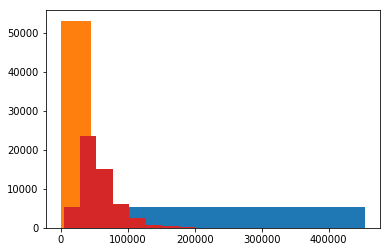

In [248]:
x = 10
n, bins_equl_n, patches = plt.hist(df.population_density, histedges_equalN(df.population_density, 10))
df['population_density_bin_equaln'] = pd.cut(df['population_density'],bins_equl_n, labels = [str(n) for n in range(len(bins_equl_n)-1)])

x = 10
n, bins_equl_width, patches = plt.hist(df.population_density, 10)
df['population_density_bin_equalwidth'] = pd.cut(df['population_density'],bins_equl_width)

n, bins, patches = plt.hist(df['mortgage_with_rate'],5)
df['mortgage_with_rate_bin'] = pd.cut(df['mortgage_with_rate'],bins, labels = [n for n in range(len(bins)-1)])

df['incentive_residential_state_level_bin'] = pd.cut(df['incentive_residential_state_level'],[0,5,8,15,18])
df['daily_solar_radiation_bin'] = pd.cut(df['daily_solar_radiation'],[0,4,5,7], labels = [n for n in range(len([0,4,5,7])-1)])

n, bins, patches = plt.hist(df['median_household_income'],10)
df['median_household_income_bin'] = pd.cut(df['median_household_income'],bins, labels = [n for n in range(len(bins)-1)])

df['age_retired']= df.population*df.age_65_74_rate + df.population*df.age_75_84_rate + df.population*df.age_more_than_85_rate 
df['age_retired_rate'] = df['age_retired'].div(df.population)

In [325]:
target = 'solar_system_count_residential'#'total_panel_area'

binned_var_omit = [col for col in df.columns if '_bin' in col and col !='daily_solar_radiation_bin']

omit = ['Unnamed: 0','fips','solar_system_count_nonresidential', 'total_panel_area', 'population_density_bin_equalwidth','population_density_bin_equaln','fips', 'county', 'state', 'electricity_price_transportation', 'total_panel_area_residential',
'total_panel_area_nonresidential',  'education_population','solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
        'tile_count','tile_count_residential', 'tile_count_nonresidential','number_of_solar_system_per_household', 'solar_system_count']

edu_omit = ['education_bachelor','education_college','education_doctoral','education_high_school_graduate','education_less_than_high_school','education_master','education_professional_school']
race_omit = ['race_asian','race_black_africa','race_indian_alaska','race_islander','race_other','race_two_more','race_white', 'race_indian_alaska_rate','race_two_more_rate']
heat_fuel_omit = ['heating_fuel_coal_coke','heating_fuel_electricity','heating_fuel_fuel_oil_kerosene','heating_fuel_gas','heating_fuel_housing_unit_count',
'heating_fuel_none','heating_fuel_other','heating_fuel_solar', 'heating_fuel_solar_rate']


edu_rate_omit = ['education_bachelor_rate','education_college_rate','education_doctoral_rate','education_high_school_graduate_rate','education_less_than_high_school_rate','education_master_rate','education_professional_school_rate']
race_rate_omit = ['race_asian_rate','race_black_africa_rate','race_indian_alaska_rate','race_islander_rate','race_other_rate','race_two_more_rate','race_white_rate','race_indian_alaska','race_two_more']
heat_fuel_rate_omit = ['heating_fuel_coal_coke_rate','heating_fuel_electricity_rate','heating_fuel_fuel_oil_kerosene_rate','heating_fuel_gas_rate','heating_fuel_housing_unit_count_rate',
'heating_fuel_none_rate','heating_fuel_other_rate','heating_fuel_solar_rate', 'heating_fuel_solar']

nonresidential = ['incentive_count_nonresidential','electricity_consume_commercial','electricity_price_overall', 'electricity_consume_industrial', 'electricity_consume_total','electricity_price_industrial','electricity_price_commercial']

regardless_omit = ['water_area', 'lon', 'heating_design_temperature']#['heating_fuel_fuel_oil_kerosene_rate','heating_fuel_fuel_oil_kerosene','race_indian_alaska_rate','race_islander_rate', 'race_indian_alaska','race_islander']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

## Building a feature set brute force

### Build a feature set by brute force one term at a time

In [146]:
X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+ nonresidential+regardless_omit)]
Y = df[target]

all_features = list(X.columns)
existing_features= ['daily_solar_radiation']
prev_score= 0

for ik in range(len(all_features)):
    feature_scores = []
    for feature in all_features:
        X = df[existing_features + [feature]]
        X_train, X_test, y_train, y_test = train_test_split(X, Y)
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(X_train, y_train)
        new_score = lin_reg.score(X_test, y_test)
        feature_scores.append(new_score)
    feature_scores =np.array(feature_scores)
    new_score = feature_scores[feature_scores.argmax()]
    new_feature = all_features.pop(feature_scores.argmax())
    if new_score>prev_score:
        print(new_feature, new_score)
        existing_features.append(new_feature)
        prev_score = new_score
#         if new_score>prev_score:
#             prev_score = new_score
#             existing_features.append(feature)
#             print(feature, new_score)


            

health_insurance_none_rate 0.246023194378
incentive_residential_state_level 0.289003075864
feedin_tariff 0.323509848638
poverty_family_count 0.335863417105
occupancy_owner_rate 0.353514526026
transportation_car_alone_rate 0.358961033025
education_bachelor 0.363415353305
housing_unit_median_gross_rent 0.365937690494
travel_time_30_39_rate 0.382676752589


### Build a feature set by brute force subtracting one term at a time

In [179]:
X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+ nonresidential+regardless_omit)]
Y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
prev_score = lin_reg.score(X_test, y_test)

all_features = list(X.columns)
existing_features= []

for ik in range(len(all_features)):
    feature_scores = []
    features = []
    for feature in all_features:
        all_features2 = all_features
        all_features2.remove(feature)
        X = df[all_features2]
        X_train, X_test, y_train, y_test = train_test_split(X, Y)
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(X_train, y_train)
        new_score = lin_reg.score(X_test, y_test)
        feature_scores.append(new_score)
        features.append(feature)
    feature_scores =np.array(feature_scores)
    max_score = feature_scores[feature_scores.argmax()]
    if max_score>prev_score:
        new_feature = features.pop(feature_scores.argmax())
        print(new_feature, max_score, prev_score)
        prev_score = max_score
    else:
        break
            

education_master 0.473348413398 0.456745041452


### Use Sklearn's feature selection function

In [261]:
from sklearn.feature_selection import SelectKBest, chi2
selected = SelectKBest(chi2, k=40).fit(X_train.loc[:, ~X_train.columns.isin(['solar_system_count_residential'])], y_train)

kbestcols = X_train.loc[:, ~X_train.columns.isin(['solar_system_count_residential'])].columns[selected.get_support()]
print(kbestcols)

Index(['average_household_income', 'employed', 'land_area',
       'per_capita_income', 'population', 'population_density',
       'poverty_family_below_poverty_level', 'poverty_family_count',
       'total_area', 'unemployed', 'median_household_income',
       'electricity_price_residential', 'electricity_consume_residential',
       'electricity_consume_commercial', 'household_count',
       'housing_unit_count', 'housing_unit_occupied_count',
       'housing_unit_median_value', 'housing_unit_median_gross_rent',
       'elevation', 'frost_days', 'air_temperature', 'earth_temperature',
       'heating_degree_days', 'cooling_degree_days',
       'incentive_count_residential', 'incentive_count_nonresidential',
       'incentive_residential_state_level',
       'incentive_nonresidential_state_level', 'net_metering', 'feedin_tariff',
       'property_tax', 'sales_tax', 'rebate', 'avg_electricity_retail_rate',
       'median_income_per_area_residential', 'income_per_area_residential',
    

In [262]:
# X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+ nonresidential+regardless_omit)]
# X = df[kbestcols] # underperformed the full culled feature set
# Y = df[target]
# X_train, X_test, y_train, y_test = train_test_split(X[kbestcols], Y)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train[kbestcols], y_train)
lin_reg.score(X_test[kbestcols], y_test)

0.39903895342565532

### Compare to full feature set

In [221]:
X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+ nonresidential+regardless_omit)]
# X = df[kbestcols] # underperformed the full culled feature set
Y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, Y)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
prev_score = lin_reg.score(X_test, y_test)

In [222]:
pred = lin_reg.predict(X_test)

In [223]:
lin_reg.score(X_test, y_test)

0.46999702488633643

In [164]:
X.columns[lin_reg.coef_.argsort()]

Index(['age_more_than_85_rate', 'household_type_family_rate', 'age_45_54_rate',
       'age_35_44_rate', 'occupation_information_rate',
       'travel_time_60_89_rate', 'age_55_64_rate', 'air_temperature',
       'travel_time_30_39_rate', 'travel_time_less_than_10_rate',
       ...
       'gini_index', 'occupation_education_rate', 'occupation_retail_rate',
       'occupancy_vacant_rate', 'occupation_construction_rate',
       'occupation_public_rate', 'employ_rate', 'voting_2016_gop_percentage',
       'voting_2016_dem_percentage', 'transportation_motorcycle_rate'],
      dtype='object', length=126)

## State as a dummy variable

In [335]:
df = df_all
state_df = pd.get_dummies(df.state)
df = pd.concat([df, state_df], axis = 1)

X = df.loc[:, ~(df.columns).isin(omit+binned_var_omit+ regardless_omit+edu_omit+race_omit+heat_fuel_omit+ regardless_omit+ nonresidential)]#+binned_var_omit)]
Y = df[target]

In [337]:
X = df.loc[:, ~(df.columns).isin([target]+ omit+edu_rate_omit+race_rate_omit+heat_fuel_rate_omit+ nonresidential+ binned_var_omit)]
# X = df[kbestcols] # underperformed the full culled feature set
Y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [338]:
from sklearn import ensemble

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [339]:
clf.score(X_test, y_test)

0.74161570753815498

In [340]:
print('under predicted', 100*sum([1 if res>=0 else 0 for res in y_test-clf.predict(X_test)])/len(y_test-clf.predict(X_test)),'% of the time')

under predicted 33.5452865064695 % of the time


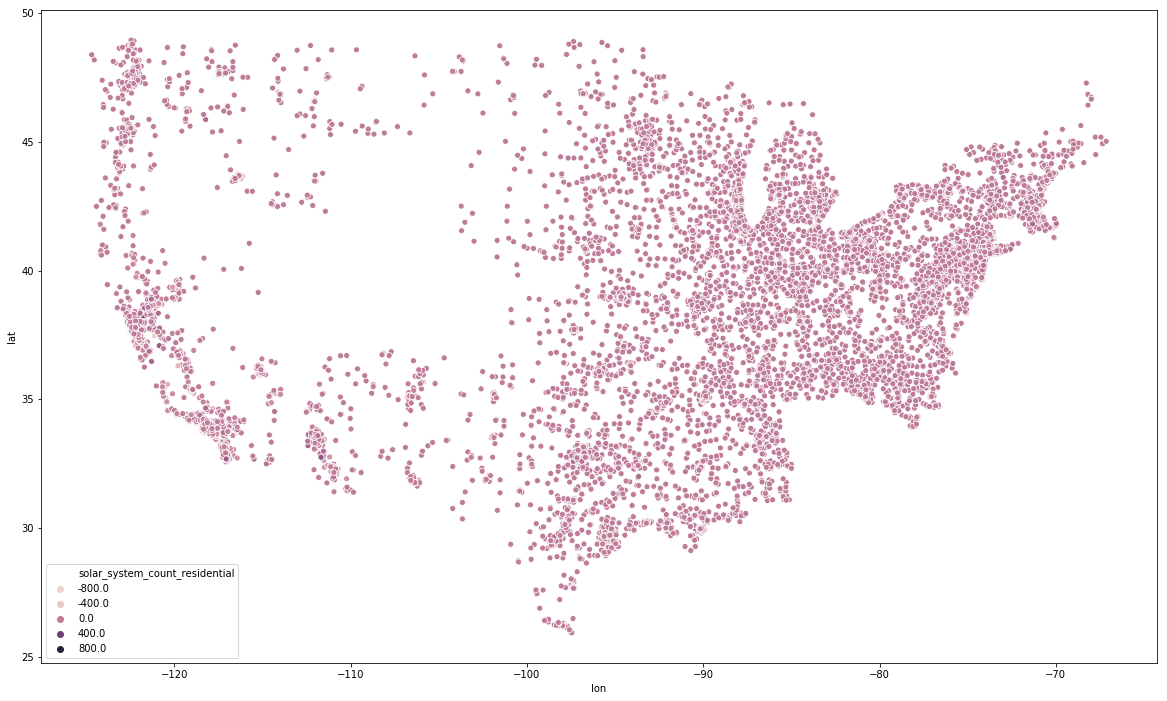

In [341]:
fig, ax = plt.subplots(figsize = [20,12])
sns.scatterplot(X_test.lon, X_test.lat, hue = y_test-clf.predict(X_test), ax = ax)

MSE: 682.1037


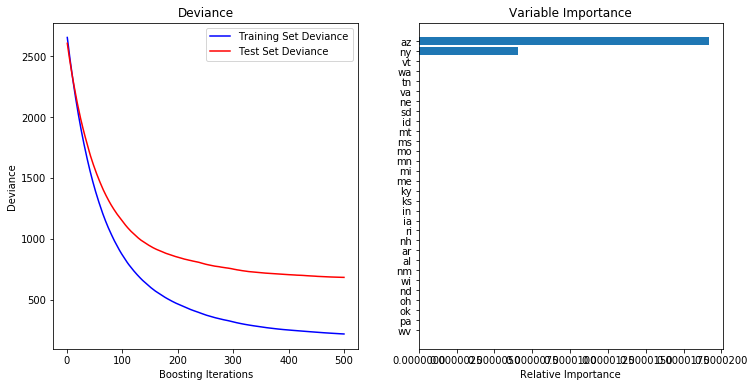

In [342]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[:30], feature_importance[sorted_idx][:30], align='center')
plt.yticks(pos[:30], X_test.columns[sorted_idx][:30])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')